In [1]:
!pip install botorch
!pip install rdkit
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 481 kB 11.9 MB/s 
     |████████████████████████████████| 727 kB 15.7 MB/s 
     |████████████████████████████████| 245 kB 32.2 MB/s 
     |████████████████████████████████| 152 kB 36.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 11.8 MB/s 


In [2]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import rdmolfiles, rdmolops, AllChem, Draw, rdDepictor, Descriptors
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Fingerprints import FingerprintMols

from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display

import torch
from botorch.models import SingleTaskGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from botorch.models.multitask import MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam
from collections import defaultdict
from tqdm import tqdm

#**Load Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
df = pd.read_csv('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Data/Binary Polymer Solution Cloud Point Database.csv')
df['Polymer Mols'] = df['Polymer SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df['Solvent Mols'] = df['Solvent SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df = df.dropna(0)

<ipython-input-4-b1f5684ff214>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df.dropna(0)


In [5]:
df

,Polymer,Polymer CAS,Polymer SMILES,Solvent,Solvent CAS,Solvent SMILES,Mw(Da),PDI,ϕ,w,P(Mpa),CP(°C),1-Phase,Ref.,Polymer Mols,Solvent Mols
0,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.12780,0.1202,4.73,-3.97,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f4bebd89890>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc8f970>
1,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.17425,0.1644,4.44,-4.08,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f4bebd26430>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc8fa50>
2,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.19746,0.1866,0.48,-3.87,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f4bebd262e0>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc8f9e0>
3,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,propionitrile,107-12-0,CCC#N,26700,1.05,0.09173,0.1100,2.28,172.28,negative,doi.org/10.1021/ma9517308,<rdkit.Chem.rdchem.Mol object at 0x7f4bebd264a0>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc8fac0>
4,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],85200,1.02,0.11958,0.1124,0.25,14.99,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f4bebd26510>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc8fb30>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6519,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.44220,0.5056,0.10,63.14,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc8f660>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebbc8ac0>
6520,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.09225,0.1159,0.10,71.08,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc8f6d0>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebbc8b30>
6521,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.11156,0.1394,0.10,72.63,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc8f740>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebbc8ba0>
6522,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.34850,0.4083,0.10,73.50,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc8f7b0>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebbc8c10>


In [6]:
#Remove rows with polyetyrene-d8 (includes deuterium)
index_d_droped = df[(df["Polymer"] == "polystyrene-d8") | (df["Solvent"] == "nitroethane-d5")].index
df_new = df.drop(index_d_droped)
df_new

,Polymer,Polymer CAS,Polymer SMILES,Solvent,Solvent CAS,Solvent SMILES,Mw(Da),PDI,ϕ,w,P(Mpa),CP(°C),1-Phase,Ref.,Polymer Mols,Solvent Mols
395,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclohexane,108-87-2,CC1CCCCC1,17500,1.06,0.11406,0.15000,82.81,21.34,positive,doi.org/10.1002/macp.1994.021950233,<rdkit.Chem.rdchem.Mol object at 0x7f4bebce22e0>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc1e900>
396,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclohexane,108-87-2,CC1CCCCC1,17500,1.06,0.18196,0.23366,80.00,21.18,positive,doi.org/10.1002/macp.1994.021950233,<rdkit.Chem.rdchem.Mol object at 0x7f4bebce2350>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc1e970>
397,polystyrene,9003-53-6,*C(C*)c1ccccc1,cyclohexanol,108-93-0,OC1CCCCC1,78800,1.12,0.00632,0.00700,0.10,73.99,positive,doi.org/10.1021/je0504865,<rdkit.Chem.rdchem.Mol object at 0x7f4bebce23c0>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc1e9e0>
398,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclopentane,96-37-7,CC1CCCC1,22100,1.03,0.11401,0.15300,1.02,27.42,positive,doi.org/10.1021/ma00107a011,<rdkit.Chem.rdchem.Mol object at 0x7f4bebce2430>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc1ea50>
399,polystyrene,9003-53-6,*C(C*)c1ccccc1,nitroethane,79-24-3,CC[N+](=O)[O-],13500,1.06,0.17990,0.17990,4.35,6.08,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f4bebce24a0>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc1eac0>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6519,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.44220,0.50560,0.10,63.14,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc8f660>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebbc8ac0>
6520,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.09225,0.11590,0.10,71.08,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc8f6d0>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebbc8b30>
6521,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.11156,0.13940,0.10,72.63,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc8f740>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebbc8ba0>
6522,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.34850,0.40830,0.10,73.50,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f4bebc8f7b0>,<rdkit.Chem.rdchem.Mol object at 0x7f4bebbc8c10>


# **Descriptor Calculation**

In [7]:
class Morgan_fingerprint(): #From Chen

    def __init__(self,mols):
        self.mols = mols
        self.bitExamples = {}
        self.keepMols = {}
        return
    
    def calculate(self,radius=2,bits=1024,vector_type="count",unhash=False):
        if vector_type not in ["count","bit"]: 
            return
        elif vector_type=="bit":
            unhash=False
            fp_all = defaultdict()
            
        mols = self.mols
        self.bits = bits
        self.radius = radius
        self.bitI_morgan =  {}
        morgan_count = defaultdict(lambda:[0]*len(mols))
        for idx,mol in enumerate(tqdm(mols)):
            self.bitI_morgan[idx] = {}
            if unhash==True:
                fp_morgan = AllChem.GetMorganFingerprint(mol, radius, bitInfo=self.bitI_morgan[idx])
            else:
                fp_morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius, 
                                                                  bitInfo=self.bitI_morgan[idx],nBits=bits)
                if vector_type=="bit":
                    arr = np.zeros((1,))
                    DataStructs.ConvertToNumpyArray(fp_morgan, arr)
                    fp_all[idx]= arr
            for key in list(self.bitI_morgan[idx].keys()):
                morgan_count["{}".format(key)][idx]=len(self.bitI_morgan[idx][key])
                #generate bit examples for visualization
                self.bitExamples[key] = idx
                self.keepMols[idx]=mol
                
        if vector_type=="bit": return pd.DataFrame.from_dict(fp_all).T #Bit type       
        return pd.DataFrame.from_dict(morgan_count)

    def visualize(self,bit_name,molSize=(250,200),verbose=True):
        bitId = int(bit_name)
        if verbose==True: print ('bit %s'%bitId)
        zid = self.bitExamples[bitId]
        mol = self.keepMols[zid]
        aid,rad = self.bitI_morgan[zid][bitId][0]
        pic1,svg  = getSubstructDepiction(mol,aid,rad,molSize=molSize)
        pic2 = Draw.DrawMorganBit(mol,bitId,self.bitI_morgan[zid])
        #display(pic)
        return pic1,pic2,svg

#for visualization #From Chen
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    #with open('morgan bits/%s.svg'%bitId, 'w') as f:
    #    f.write(svg)
    return SVG(svg.replace('svg:','')),svg 

def getSubstructDepiction(mol,atomID,radius,molSize=(450,200)):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))       
    else:
        atomsToUse = [atomID]
        env=None
    return moltosvg(mol,molSize=molSize,highlightAtoms=atomsToUse)

In [8]:
#MF for polymer
mf_poly = Morgan_fingerprint(df_new["Polymer Mols"].values)
fp_poly = mf_poly.calculate(radius=2,bits=1024,vector_type="count",unhash=False)
fp_poly = fp_poly.dropna(1)

#MF for solvent
mf_sol = Morgan_fingerprint(df_new["Solvent Mols"].values)
fp_sol = mf_sol.calculate(radius=2,bits=1024,vector_type="count",unhash=False)
fp_sol = fp_sol.dropna(1)

100%|██████████| 4833/4833 [00:00<00:00, 9168.08it/s]
<ipython-input-8-875bed0b3429>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  fp_poly = fp_poly.dropna(1)
100%|██████████| 4833/4833 [00:00<00:00, 15480.30it/s]
<ipython-input-8-875bed0b3429>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  fp_sol = fp_sol.dropna(1)


In [9]:
fp_poly.head()

,1,64,80,170,175,226,247,341,356,389,...,566,587,863,875,103,578,658,770,932,968
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
fp_sol.head()

,2,4,33,117,124,285,301,890,926,973,...,512,781,831,378,656,777,386,799,896,709
0,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0,0,0,0,2,2,5,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,2,1,1,2,2,4,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Descriptor Combination (Poly_MF/Sol_MF)**

In [11]:
fp_sol.columns

Index(['2', '4', '33', '117', '124', '285', '301', '890', '926', '973',
       ...
       '512', '781', '831', '378', '656', '777', '386', '799', '896', '709'],
      dtype='object', length=173)

In [12]:
fp_sol_new = fp_sol.rename(columns=lambda n: n + '*')

In [13]:
fp_sol_new

,2*,4*,33*,117*,124*,285*,301*,890*,926*,973*,...,512*,781*,831*,378*,656*,777*,386*,799*,896*,709*
0,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0,0,0,0,2,2,5,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,2,1,1,2,2,4,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
fp_com_mf = pd.concat([fp_poly, fp_sol_new, df_new.reset_index(drop=True)[["Mw(Da)", "PDI", "ϕ", "w", "P(Mpa)", "1-Phase", "CP(°C)"]]], axis=1)
fp_com_mf

,1,64,80,170,175,226,247,341,356,389,...,799*,896*,709*,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,positive,21.34
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,positive,21.18
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,positive,73.99
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,positive,27.42
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,positive,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.44220,0.50560,0.10,negative,63.14
4829,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.09225,0.11590,0.10,negative,71.08
4830,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.11156,0.13940,0.10,negative,72.63
4831,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.34850,0.40830,0.10,negative,73.50


In [15]:
#For 1-Phase, use LabelEncoder to transfer str to int.
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(fp_com_mf["1-Phase"])

fp_com_mf["1-Phase"] = LE.fit_transform(fp_com_mf["1-Phase"])
fp_com_mf

,1,64,80,170,175,226,247,341,356,389,...,799*,896*,709*,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,1,21.34
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,1,21.18
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,1,73.99
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,1,27.42
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,1,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.44220,0.50560,0.10,0,63.14
4829,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.09225,0.11590,0.10,0,71.08
4830,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.11156,0.13940,0.10,0,72.63
4831,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.34850,0.40830,0.10,0,73.50


# **Model Building**

In [16]:
# A list for the evaluation result
rmse_sum = {}
r2_sum = {}

## Principle Component Regression (PCA)

In [17]:
X = fp_com_mf.iloc[:, :-1]
y = fp_com_mf.iloc[:, -1]

### w/o pipeline

In [18]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
#PCA
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
model = LinearRegression()

std_X_train = std.fit_transform(X_train)

pca = PCA(n_components=64)

X_train_reduced = pca.fit_transform(std_X_train)

model.fit(X_train_reduced, y_train)
y_train_pred = model.predict(X_train_reduced)

r2_score(y_train_pred, y_train)

0.8071294136585352

In [ ]:
model = LinearRegression()

r2s = []
rmses = []
comp_num = []

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

#PCA
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std_X_train = std.fit_transform(X_train)
std_X_test = std.fit_transform(X_test)

for idx, comp in enumerate(range(1, len(X.columns)+1)):
  pca = PCA(n_components=comp)
  
  X_train_reduced = pca.fit_transform(std_X_train)

  model.fit(X_train_reduced, y_train)
  y_train_pred = model.predict(X_train_reduced)
  
  r2 = r2_score(y_train_pred, y_train)
  rmse = mean_squared_error(y_train_pred, y_train, squared=False)

  comp_num.append(idx+1)
  r2s.append(r2)
  rmses.append(rmse)

Text(0, 0.5, '')

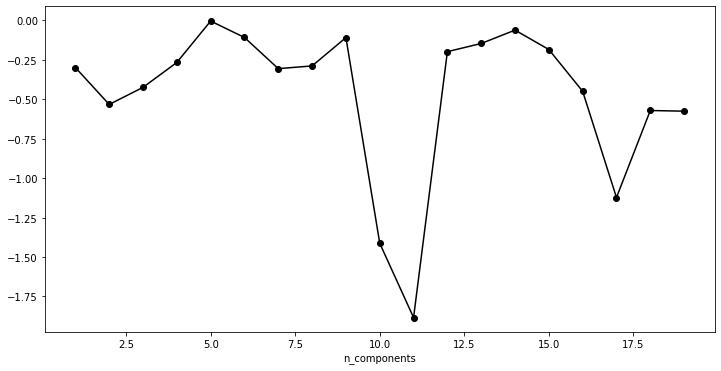

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(comp_num, r2s, "k-o")
plt.xlabel("n_components")
plt.ylabel("r square")

### w/ pipeline

In [20]:
from sklearn.model_selection import train_test_split

#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
PCR_model = make_pipeline(StandardScaler(), 
                          PCA(n_components=64), 
                          LinearRegression())
PCR_model.fit(X_train, y_train)
PCR_model.score(X_test, y_test)

0.8428375058403851

In [ ]:
# パイプライン定義
PCR_model = make_pipeline(StandardScaler(), PCA(), LinearRegression())

# 探索範囲
param = {'pca__n_components' : np.arange(1, len(X.columns)+1)}

# グリッドサーチのインスタンス生成
PCR_grid = GridSearchCV(PCR_model,
                        param_grid=param,
                        cv=10
                        ) 

# グリッドサーチの実行
PCR_grid.fit(X_train, y_train)

# 最適パラメータ
PCR_grid.best_params_

{'pca__n_components': 64}

In [ ]:
PCR_grid.score(X_train, y_train)

# **Summary**

In [ ]:
summary = pd.DataFrame(rmse_sum, index=['Train', 'Test'])
summary.style.set_caption("Table of RMSE")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,GP
Train,0.644810,0.399926,0.610615,0.020649,0.156326
Test,0.618509,0.391126,0.585712,0.045337,0.157947


In [ ]:
summary = pd.DataFrame(r2_sum, index=['Train', 'Test'])
summary.style.set_caption("Table of R square")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,GP
Train,0.586920,0.841098,0.629571,0.999576,0.975721
Test,0.607150,0.842903,0.647707,0.997889,0.974381
